## Relation Between Food Cuisines

Steps involved in this notebook:
1. Import the required packages
2. 

In [54]:
# Basic Packages
import re
import requests

# Packges for Data Manipulation
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

pd.set_option('display.max_columns', None) # Enables the display of all the columns

# Packages for Visualization
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Packages for getting geospatial coordinates
from geopy.geocoders import Nominatim
import geocoder

from sklearn.cluster import KMeans
%matplotlib inline

Load the data for performing inital analysis with *Toronto Postal Codes*. **Change the file path when replicating.**

In [55]:
toronto_df = pd.read_csv(r'Data Files\Toronto Postal Codes.csv')
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [56]:
toronto_df = toronto_df.sort_values(by = ['PostalCode'], ascending = True).reset_index(drop = True)
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Rouge,43.806686,-79.194353
1,M1B,Scarborough,Malvern,43.806686,-79.194353
2,M1C,Scarborough,Port Union,43.784535,-79.160497
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
4,M1C,Scarborough,Highland Creek,43.784535,-79.160497


Using the geolocator package, we get the latitude and longitude of the location. The attribute *user_agent* is used in `Nominatim` method in order to remove the warning caused. The latitude and longitude returned is *approximately* correct.

In [58]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
latitude_tor = location.latitude
longitude_tor = location.longitude

print("Toronto latitude: {} and longitude: {}".format(latitude_tor, longitude_tor))

Toronto latitude: 43.653963 and longitude: -79.387207


Using `folium` generate a map for better understanding of the distribution. `zoom_start` attribute is pretty much user preference, it need not be a fixed value. But 10 seems perfect for this map.  
In order to create the popup labels, iterate through the Latitude, Longitude, Borough, Neighborhood and use the `Popup` method of folium to generate the label. Then using the `CircleMarker` method, plot the points on the map.

In [60]:
map_toronto = folium.Map(location = [latitude_tor, longitude_tor], zoom_start = 10)

for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_toronto)
    
map_toronto

In a new dataframe store the *Scarborough* borough values. `reset_index` with a drop = True parameter is used in order to generate index starting from 0. 

In [61]:
scar_df = toronto_df[toronto_df['Borough'] == 'Scarborough'].reset_index(drop = True)
scar_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Rouge,43.806686,-79.194353
1,M1B,Scarborough,Malvern,43.806686,-79.194353
2,M1C,Scarborough,Port Union,43.784535,-79.160497
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
4,M1C,Scarborough,Highland Creek,43.784535,-79.160497


In [62]:
address = 'Scarborough, ON'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
latitude_scar = location.latitude
longitude_scar = location.longitude

print('Scaarborough latitude: {} and longitude: {}'.format(latitude_scar, longitude_scar))

Scaarborough latitude: 43.773077 and longitude: -79.257774


In [63]:
map_scar = folium.Map(location = [latitude_scar, longitude_scar], zoom_start = 10)

for lat, lng, neighborhood, borough in zip(scar_df['Latitude'], scar_df['Longitude'], scar_df['Neighborhood'], scar_df['Borough']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_scar)
    
map_scar

In [64]:
neighborhood_latitude = scar_df.loc[0, 'Latitude'] # get latitude of first entry
neighborhood_longitude = scar_df.loc[0, 'Longitude'] #get longitude of first entry
neighborhood_name = scar_df.loc[0, 'Neighborhood']

print("Latitude: {}, \nLongitude: {}, \nNeighborhood Name: {}".format(neighborhood_latitude, 
                       neighborhood_longitude, 
                       neighborhood_name))

Latitude: 43.8066863, 
Longitude: -79.19435340000003, 
Neighborhood Name: Rouge


Use the **Foursquare API** to get the loction data for the particular neighborhood. The credentials are necessary to get the data. **Change the credentials when using** 

In [65]:
CLIENT_ID = 'BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP' # Change when replicating
CLIENT_SECRET = 'WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY' # Change when replicating
VERSION = '20181204'

print("My Credentials: ")
print("CLIENT_ID: " + CLIENT_ID)
print("CLIENT_SECRET: " + CLIENT_SECRET)

My Credentials: 
CLIENT_ID: BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP
CLIENT_SECRET: WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY


Now that we have the CLIENT_ID and CLIENT_SECRET, we can now proceed to generate the url needed for data extraction.

In [66]:
LIMIT = 100
# Radius is made 1000 because, with radius as 500, the results generated are not much.
radius = 1000

# using the url convention, create the url to get the requests
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP&client_secret=WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY&v=20181204&ll=43.8066863,-79.19435340000003&radius=1000&limit=100'

Now using the `requests` package get the JSON file for the url

In [67]:
results = requests.get(url).json() # Get the data in JSON format
results

{'meta': {'code': 200, 'requestId': '5c1b9c76db04f53ab8ad9478'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 16,
  'suggestedBounds': {'ne': {'lat': 43.815686309000014,
    'lng': -79.18190576146083},
   'sw': {'lat': 43.79768629099999, 'lng': -79.20680103853923}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d669cba83865481c948fa53',
       'name': 'Images Salon & Spa',
       'location': {'address': '8130 Sheppard Ave E',
        'crossStreet': 'Morningside Ave',
        'lat': 43.80228301948931,
        'lng': -79.19856472801668,
        'labeledLatLngs'

Use the below function to get the category types.

In [68]:
def get_category_type(row):
    '''
    Helper code to get the category type
    '''
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [69]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # Flatten the JSON to tabular data

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis = 1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Images Salon & Spa,Spa,43.802283,-79.198565
1,Caribbean Wave,Caribbean Restaurant,43.798558,-79.195777
2,Wendy's,Fast Food Restaurant,43.802008,-79.198080
3,Harvey's,Fast Food Restaurant,43.800106,-79.198258
4,Wendy's,Fast Food Restaurant,43.807448,-79.199056


The below function returns nearby venues. It simply iterates for every neighborhood and generates the url from which the data is extracted and modified for our use.

In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    '''
    This function returns the nearby venues
    '''
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [72]:
scar_venues = getNearbyVenues(names=scar_df['Neighborhood'],
                                   latitudes=scar_df['Latitude'],
                                   longitudes=scar_df['Longitude']
                                  )

Rouge
Malvern
Port Union
Rouge Hill
Highland Creek
Guildwood
Morningside
West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park
Ionview
Kennedy Park
Golden Mile
Oakridge
Clairlea
Cliffcrest
Scarborough Village West
Cliffside
Cliffside West
Birch Cliff
Wexford Heights
Dorset Park
Scarborough Town Centre
Maryvale
Wexford
Agincourt
Sullivan
Clarks Corners
Tam O'Shanter
Milliken
Agincourt North
L'Amoreaux East
Steeles East
Steeles West
L'Amoreaux West
Upper Rouge


In [73]:
print(scar_venues.shape)
scar_venues.head()

(208, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rouge,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Malvern,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
2,Port Union,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,Rouge Hill,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,Highland Creek,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar


In [74]:
scar_venues.loc[-1] = ['Upper Rouge', 43.83455, -79.2069, "Al's Wine", 43.83455, -79.2069, "Bar"]

In [75]:
scar_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rouge,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Malvern,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
2,Port Union,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,Rouge Hill,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,Highland Creek,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar


Onehot Encode the  categories

In [76]:
scar_onehot = pd.get_dummies(scar_venues[['Venue Category']], prefix = '', prefix_sep = "")

scar_onehot['Neighborhood'] = scar_venues['Neighborhood']

fixed_columns = [scar_onehot.columns[-1]] + list(scar_onehot.columns[:-1])
scar_onehot = scar_onehot[fixed_columns]

scar_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Convenience Store,Department Store,Discount Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,General Entertainment,Grocery Store,Hakka Restaurant,Hobby Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lounge,Medical Center,Mexican Restaurant,Middle Eastern Restaurant,Motel,Movie Theater,Noodle House,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Rental Car Location,Sandwich Place,Shopping Mall,Skating Rink,Soccer Field,Spa,Thai Restaurant,Train Station,Vietnamese Restaurant
0,Rouge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Malvern,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Port Union,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Rouge Hill,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Highland Creek,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
scar_grouped = scar_onehot.groupby('Neighborhood').mean().reset_index()
scar_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Coffee Shop,College Stadium,Convenience Store,Department Store,Discount Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,General Entertainment,Grocery Store,Hakka Restaurant,Hobby Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lounge,Medical Center,Mexican Restaurant,Middle Eastern Restaurant,Motel,Movie Theater,Noodle House,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Rental Car Location,Sandwich Place,Shopping Mall,Skating Rink,Soccer Field,Spa,Thai Restaurant,Train Station,Vietnamese Restaurant
0,Agincourt,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.25,0.000000,0.000000,0.00,0.000000,0.0,0.25,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,0.0
1,Agincourt North,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0
2,Birch Cliff,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.25,0.000000,0.0,0.00,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.000000,0.25,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,0.0
3,Cedarbrae,0.0,0.0,0.142857,0.0,0.142857,0.142857,0.0,0.00,0.000000,0.000000,0.00,0.142857,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.142857,0.00,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.142857,0.0,0.0
4,Clairlea,0.0,0.0,0.000000,0.0,0.222222,0.000000,0.0,0.00,0.222222,0.111111,0.00,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.111111,0.000000,0.00,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.111111,0.0,0.000000,0.0,0.0


In [78]:
scar_grouped_neighbor = scar_grouped['Neighborhood'] # Store the neighborhood column in a variable

Store all the column names that end with *Restaurant*.

In [79]:
scar_grouped = scar_grouped.loc[:, scar_grouped.columns.str.endswith('Restaurant')]
scar_grouped.head()

,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Hakka Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Thai Restaurant,Vietnamese Restaurant
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.142857,0.0,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0
4,0.0,0.000000,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [80]:
# Add the neighborhood column
scar_grouped['Neighborhood'] = scar_grouped_neighbor
scar_grouped.head()

,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Hakka Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Thai Restaurant,Vietnamese Restaurant,Neighborhood
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,Agincourt
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,Agincourt North
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,Birch Cliff
3,0.0,0.142857,0.0,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,Cedarbrae
4,0.0,0.000000,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,Clairlea


In [81]:
# Rearrange the neighborhood column to first
cols = list(scar_grouped)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
scar_grouped = scar_grouped.loc[:, cols]
scar_grouped.head()

,Neighborhood,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Hakka Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Agincourt,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Agincourt North,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Birch Cliff,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Cedarbrae,0.0,0.142857,0.0,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0
4,Clairlea,0.0,0.000000,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Print out the venues in the neighborhoods

In [82]:
num_top_venues = 5

for hood in scar_grouped['Neighborhood']:
    print('------- ' + hood + ' -------')
    temp = scar_grouped[scar_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue', 'Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

------- Agincourt -------
                  Venue  Frequency
0   American Restaurant        0.0
1  Caribbean Restaurant        0.0
2    Chinese Restaurant        0.0
3  Fast Food Restaurant        0.0
4      Hakka Restaurant        0.0


------- Agincourt North -------
                  Venue  Frequency
0   American Restaurant        0.0
1  Caribbean Restaurant        0.0
2    Chinese Restaurant        0.0
3  Fast Food Restaurant        0.0
4      Hakka Restaurant        0.0


------- Birch Cliff -------
                  Venue  Frequency
0   American Restaurant        0.0
1  Caribbean Restaurant        0.0
2    Chinese Restaurant        0.0
3  Fast Food Restaurant        0.0
4      Hakka Restaurant        0.0


------- Cedarbrae -------
                  Venue  Frequency
0  Caribbean Restaurant       0.14
1      Hakka Restaurant       0.14
2       Thai Restaurant       0.14
3   American Restaurant       0.00
4    Chinese Restaurant       0.00


------- Clairlea -------
               

4  Fast Food Restaurant       0.00


------- Wexford -------
                       Venue  Frequency
0  Middle Eastern Restaurant       0.22
1        American Restaurant       0.00
2       Caribbean Restaurant       0.00
3         Chinese Restaurant       0.00
4       Fast Food Restaurant       0.00


------- Wexford Heights -------
                       Venue  Frequency
0          Indian Restaurant       0.29
1         Chinese Restaurant       0.14
2  Latin American Restaurant       0.14
3      Vietnamese Restaurant       0.14
4        American Restaurant       0.00


------- Woburn -------
                  Venue  Frequency
0     Korean Restaurant       0.33
1   American Restaurant       0.00
2  Caribbean Restaurant       0.00
3    Chinese Restaurant       0.00
4  Fast Food Restaurant       0.00




The below function return most common venues

In [83]:
def return_most_common_venues(row, num_top_venues):
    """
    Returns most common venues
    """
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe based on the top venues

In [126]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_scar = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_scar['Neighborhood'] = scar_grouped['Neighborhood']

for ind in np.arange(scar_grouped.shape[0]):
    neighborhoods_venues_sorted_scar.iloc[ind, 1:] = return_most_common_venues(scar_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_scar

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant
1,Agincourt North,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant
2,Birch Cliff,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant
3,Cedarbrae,Thai Restaurant,Hakka Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant
4,Clairlea,Fast Food Restaurant,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant
5,Clarks Corners,Thai Restaurant,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant
6,Cliffcrest,American Restaurant,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant
7,Cliffside,American Restaurant,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant
8,Cliffside West,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant
9,Dorset Park,Indian Restaurant,Vietnamese Restaurant,Latin American Restaurant,Chinese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant


Using the KMeans method cluster the neighborhood

In [127]:
kclusters = 5

scar_grouped_clustering = scar_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scar_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 3, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0,
       0, 0, 1, 0, 2, 0, 4, 0, 3, 3, 3, 0, 0, 0, 2, 0])

In [128]:
scar_merged = scar_df

scar_merged['Cluster Labels'] = kmeans.labels_

scar_merged = scar_merged.join(neighborhoods_venues_sorted_scar.set_index('Neighborhood'), on='Neighborhood')

scar_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,Rouge,43.806686,-79.194353,0,Fast Food Restaurant,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant
1,M1B,Scarborough,Malvern,43.806686,-79.194353,0,Fast Food Restaurant,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant
2,M1C,Scarborough,Port Union,43.784535,-79.160497,0,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497,0,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant
4,M1C,Scarborough,Highland Creek,43.784535,-79.160497,0,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant


In [129]:
map_clusters = folium.Map(location = [latitude_scar, longitude_scar], zoom_start = 11)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(scar_merged['Latitude'], scar_merged['Longitude'], scar_merged['Neighborhood'], scar_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

Import the Nova Scotia Dataset

In [88]:
df_nova = pd.read_csv(r'Data Files\Nova Scotia Postal Code.csv')
df_nova.head()

,Postal Code,Boroughs,Neighborhood,Latitude,Longitude
0,B0C,North Victoria County,Dingwall,46.6482,-60.5396
1,B0E,West Cape Breton Island,Baddeck,46.1133,-61.0251
2,B0H,Canso region,Havre Boucher,45.3335,-61.8333
3,B0J,Mainland east shore,Lunenburg,44.9419,-62.6471
4,B0K,Southern Northumberland Strait,Pictou,45.6138,-62.9506


In [89]:
address = 'Nova Scotia'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
latitude_ns = location.latitude
longitude_ns = location.longitude

print("Nova Scotia latitude of: {} and longitude: {}".format(latitude_ns, longitude_ns))

Nova Scotia latitude of: 45.1960403 and longitude: -63.1653789


In [130]:
map_nova = folium.Map(location = [latitude_ns, longitude_ns], zoom_start = 7.2)
for lat, lng, borough, neighborhood in zip(df_nova['Latitude'], df_nova['Longitude'], df_nova['Boroughs'], df_nova['Neighborhood']):
    label = '{}, {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_nova)
    
map_nova

Create a new dataset for Halifax Data values

In [120]:
halifax_data = df_nova[df_nova['Boroughs'].str.contains('Halifax')].reset_index(drop = True)
halifax_data.head()

,Postal Code,Boroughs,Neighborhood,Latitude,Longitude
0,B3H,Halifax Lower Harbour,Halifax Lower Harbour,44.6344,-63.5822
1,B3J,Halifax Mid-Harbour Nova Scotia Provincial Gov...,Halifax Mid-Harbour Nova Scotia Provincial Gov...,44.6451,-63.5762
2,B3K,Halifax Upper Harbour,Halifax Upper Harbour,44.6620,-63.6017
3,B3L,Halifax Central,Halifax Central,44.6508,-63.6146
4,B3M,Halifax Bedford Basin,Halifax Bedford Basin,44.6784,-63.6582


In [93]:
address = 'Halifax, Nova Scotia'
geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
latitude_hal = location.latitude
longitude_hal = location.longitude
print('The Latitude of Halifax: {} and the Longitude: {}'.format(latitude_hal, longitude_hal))

The Latitude of Halifax: 44.6486237 and the Longitude: -63.5859487


In [94]:
map_hal = folium.Map(location = [latitude_hal, longitude_hal], zoom_start = 12)
for lat, lng, label in zip(halifax_data['Latitude'], halifax_data['Longitude'], halifax_data['Boroughs']):
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'blue', 
    fill = True, 
    fill_color = '#3186cc', 
    fill_opacity = 0.7).add_to(map_hal)
map_hal

In [95]:
CLIENT_ID = 'BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP' # Change when replicating
CLIENT_SECRET = 'WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY' # Change when replicating
VERSION = '20181204'

print("My Credentials: ")
print("CLIENT_ID: " + CLIENT_ID)
print("CLIENT_SECRET: " + CLIENT_SECRET)

My Credentials: 
CLIENT_ID: BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP
CLIENT_SECRET: WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY


In [96]:
neighborhood_latitude = halifax_data.loc[0, 'Latitude'] # get latitude of first entry
neighborhood_longitude = halifax_data.loc[0, 'Longitude'] #get longitude of first entry
neighborhood_name = halifax_data.loc[0, 'Neighborhood']

print("Latitude: {}, \nLongitude: {}, \nNeighborhood Name: {}".format(neighborhood_latitude, 
                       neighborhood_longitude, 
                       neighborhood_name))

Latitude: 44.6344, 
Longitude: -63.5822, 
Neighborhood Name: Halifax Lower Harbour


In [97]:
LIMIT = 100

radius = 500
# using the url convention, create the url to get the requests
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=BL4OMDGY22KNROQIDK1SH2B0HKWTRZRDTXUTZVQBOJ1YZXLP&client_secret=WUYFQMZ2L1CN512RXLUIZCWDBDPNBLR5EAMAWDYDJIZ3QEEY&v=20181204&ll=44.6344,-63.5822&radius=500&limit=100'

In [98]:
results_hal = requests.get(url).json() # Get the data in JSON format
results_hal

{'meta': {'code': 200, 'requestId': '5c1ba5bb6a607133f3af7b22'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Halifax',
  'headerFullLocation': 'Halifax',
  'headerLocationGranularity': 'city',
  'totalResults': 6,
  'suggestedBounds': {'ne': {'lat': 44.6389000045, 'lng': -63.575888062083315},
   'sw': {'lat': 44.6298999955, 'lng': -63.588511937916685}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b5f1428f964a520f9a429e3',
       'name': 'Uncommon Grounds',
       'location': {'address': '1030 South Park St.',
        'crossStreet': 'Victoria Road',
        'lat': 44.63545331104972,
        'lng': -63.57656058303846,
        'labeledLatLngs': [{'label': 'display',
         

In [99]:
venues = results_hal['response']['groups'][0]['items']

nearby_venues_hal = json_normalize(venues) # Flatten the JSON to tabular data

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_hal = nearby_venues_hal.loc[:, filtered_columns]

nearby_venues_hal['venue.categories'] = nearby_venues_hal.apply(get_category_type, axis = 1)

nearby_venues_hal.columns = [col.split(".")[-1] for col in nearby_venues_hal.columns]
nearby_venues_hal.head()

,name,categories,lat,lng
0,Uncommon Grounds,Coffee Shop,44.635453,-63.576561
1,The Gorsebrook Lounge,College Cafeteria,44.632125,-63.579914
2,Tim Hortons,Coffee Shop,44.632189,-63.580100
3,Subway,Sandwich Place,44.637695,-63.584148
4,Just Us! Coffeehouse,Café,44.632061,-63.581024


In [100]:
halifax_venues = getNearbyVenues(names=halifax_data['Neighborhood'],
                                   latitudes=halifax_data['Latitude'],
                                   longitudes=halifax_data['Longitude']
                                  )

Halifax Lower Harbour
Halifax Mid-Harbour Nova Scotia Provincial Government
Halifax Upper Harbour
Halifax Central
Halifax Bedford Basin
Halifax South Central
Halifax North West Arm
Halifax South
Halifax West


In [101]:
print(halifax_venues.shape)
halifax_venues.head()

(145, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Halifax Lower Harbour,44.6344,-63.5822,Uncommon Grounds,44.635453,-63.576561,Coffee Shop
1,Halifax Lower Harbour,44.6344,-63.5822,The Gorsebrook Lounge,44.632125,-63.579914,College Cafeteria
2,Halifax Lower Harbour,44.6344,-63.5822,Tim Hortons,44.632189,-63.580100,Coffee Shop
3,Halifax Lower Harbour,44.6344,-63.5822,Subway,44.637695,-63.584148,Sandwich Place
4,Halifax Lower Harbour,44.6344,-63.5822,Just Us! Coffeehouse,44.632061,-63.581024,Café


In [102]:
halifax_onehot = pd.get_dummies(halifax_venues[['Venue Category']], prefix = '', prefix_sep = "")

halifax_onehot['Neighborhood'] = halifax_venues['Neighborhood']

fixed_columns = [halifax_onehot.columns[-1]] + list(halifax_onehot.columns[:-1])
halifax_onehot = halifax_onehot[fixed_columns]

halifax_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Bakery,Bank,Bar,Bistro,Bookstore,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Construction & Landscaping,Convention Center,Cosmetics Shop,Discount Store,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,Gastropub,Gourmet Shop,Grocery Store,Gym,Health & Beauty Service,Historic Site,Hobby Shop,Hockey Arena,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Lingerie Store,Liquor Store,Medical Lab,Middle Eastern Restaurant,Mobile Phone Shop,Museum,Park,Pharmacy,Pizza Place,Plaza,Pool,Pub,Record Shop,Restaurant,Sandwich Place,School,Seafood Restaurant,Shopping Mall,Skating Rink,Spa,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Halifax Lower Harbour,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Halifax Lower Harbour,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Halifax Lower Harbour,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Halifax Lower Harbour,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Halifax Lower Harbour,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
halifax_grouped = halifax_onehot.groupby('Neighborhood').mean().reset_index()
halifax_grouped

,Neighborhood,American Restaurant,Art Gallery,Bakery,Bank,Bar,Bistro,Bookstore,Breakfast Spot,Burger Joint,Burrito Place,Bus Station,Café,Candy Store,Caribbean Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Construction & Landscaping,Convention Center,Cosmetics Shop,Discount Store,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,Gastropub,Gourmet Shop,Grocery Store,Gym,Health & Beauty Service,Historic Site,Hobby Shop,Hockey Arena,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Lingerie Store,Liquor Store,Medical Lab,Middle Eastern Restaurant,Mobile Phone Shop,Museum,Park,Pharmacy,Pizza Place,Plaza,Pool,Pub,Record Shop,Restaurant,Sandwich Place,School,Seafood Restaurant,Shopping Mall,Skating Rink,Spa,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Halifax Bedford Basin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Halifax Central,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.107143,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.035714,0.000000,0.000000,0.178571,0.0,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.035714,0.000000,0.071429,0.000000,0.0,0.000000,0.035714,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.035714,0.0,0.000000,0.035714,0.0,0.000000,0.035714,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Halifax Lower Harbour,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Halifax Mid-Harbour Nova Scotia Provincial Gov...,0.012658,0.012658,0.025316,0.012658,0.037975,0.012658,0.025316,0.037975,0.025316,0.000000,0.0,0.012658,0.012658,0.000000,0.012658,0.012658,0.012658,0.063291,0.000000,0.012658,0.000000,0.012658,0.000000,0.000000,0.000000,0.012658,0.012658,0.000000,0.0,0.000000,0.012658,0.025316,0.000000,0.012658,0.012658,0.000000,0.012658,0.000000,0.012658,0.050633,0.000000,0.025316,0.012658,0.012658,0.000000,0.012658,0.0,0.000000,0.000000,0.012658,0.000000,0.000000,0.025316,0.012658,0.000000,0.063291,0.012658,0.063291,0.000000,0.0,0.025316,0.000000,0.0,0.012658,0.000000,0.037975,0.037975,0.012658,0.012658,0.012658,0.000000,0.025316,0.012658,0.012658,0.012658,0.012658
4,Halifax Upper Harbour,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.0,0.041667,0.000000,0.041667,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,

In [104]:
halifax_grouped_neighbor = halifax_grouped['Neighborhood']

In [105]:
halifax_grouped = halifax_grouped.loc[:, halifax_grouped.columns.str.endswith('Restaurant')]
halifax_grouped.head()

,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.178571,0.000000,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.012658,0.000000,0.012658,0.012658,0.000000,0.025316,0.012658,0.000000,0.063291,0.025316,0.037975,0.012658,0.025316,0.012658,0.012658
4,0.000000,0.041667,0.000000,0.000000,0.041667,0.041667,0.000000,0.083333,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000


In [106]:
halifax_grouped['Neighborhood'] = halifax_grouped_neighbor
halifax_grouped.head()

C:\Users\kchai\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Neighborhood
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Halifax Bedford Basin
1,0.000000,0.000000,0.000000,0.000000,0.178571,0.000000,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Halifax Central
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Halifax Lower Harbour
3,0.012658,0.000000,0.012658,0.012658,0.000000,0.025316,0.012658,0.000000,0.063291,0.025316,0.037975,0.012658,0.025316,0.012658,0.012658,Halifax Mid-Harbour Nova Scotia Provincial Gov...
4,0.000000,0.041667,0.000000,0.000000,0.041667,0.041667,0.000000,0.083333,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000,Halifax Upper Harbour


In [107]:
cols = list(halifax_grouped)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
halifax_grouped = halifax_grouped.loc[:, cols]
halifax_grouped.head()

,Neighborhood,American Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Halifax Bedford Basin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Halifax Central,0.000000,0.000000,0.000000,0.000000,0.178571,0.000000,0.035714,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Halifax Lower Harbour,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Halifax Mid-Harbour Nova Scotia Provincial Gov...,0.012658,0.000000,0.012658,0.012658,0.000000,0.025316,0.012658,0.000000,0.063291,0.025316,0.037975,0.012658,0.025316,0.012658,0.012658
4,Halifax Upper Harbour,0.000000,0.041667,0.000000,0.000000,0.041667,0.041667,0.000000,0.083333,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000


In [108]:
num_top_venues = 5

for hood  in halifax_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = halifax_grouped[halifax_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Halifax Bedford Basin----
                     venue  freq
0      American Restaurant   0.0
1     Caribbean Restaurant   0.0
2       Chinese Restaurant   0.0
3  Comfort Food Restaurant   0.0
4     Fast Food Restaurant   0.0


----Halifax Central----
                  venue  freq
0  Fast Food Restaurant  0.18
1   Japanese Restaurant  0.04
2            Restaurant  0.04
3   American Restaurant  0.00
4  Caribbean Restaurant  0.00


----Halifax Lower Harbour----
                     venue  freq
0      American Restaurant   0.0
1     Caribbean Restaurant   0.0
2       Chinese Restaurant   0.0
3  Comfort Food Restaurant   0.0
4     Fast Food Restaurant   0.0


----Halifax Mid-Harbour Nova Scotia Provincial Government----
                venue  freq
0          Restaurant  0.06
1    Sushi Restaurant  0.04
2  Italian Restaurant  0.03
3  Seafood Restaurant  0.03
4  Turkish Restaurant  0.03


----Halifax Upper Harbour----
                       venue  freq
0  Middle Eastern Restaurant  0.08
1 

In [109]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [132]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_hal = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_hal['Neighborhood'] = halifax_grouped['Neighborhood']

for ind in np.arange(halifax_grouped.shape[0]):
    neighborhoods_venues_sorted_hal.iloc[ind, 1:] = return_most_common_venues(halifax_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_hal

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Halifax Bedford Basin,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant
1,Halifax Central,Fast Food Restaurant,Restaurant,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Middle Eastern Restaurant
2,Halifax Lower Harbour,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant
3,Halifax Mid-Harbour Nova Scotia Provincial Gov...,Restaurant,Sushi Restaurant,Turkish Restaurant,Seafood Restaurant,Italian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Japanese Restaurant,Comfort Food Restaurant
4,Halifax Upper Harbour,Middle Eastern Restaurant,Sushi Restaurant,Seafood Restaurant,Italian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant
5,Halifax West,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant


Let's take a look into the venues once more.

In [134]:
neighborhoods_venues_sorted_scar.head() # Scarborough Venues

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant
1,Agincourt North,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant
2,Birch Cliff,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Hakka Restaurant
3,Cedarbrae,Thai Restaurant,Hakka Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant
4,Clairlea,Fast Food Restaurant,Vietnamese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Latin American Restaurant,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant


In [137]:
neighborhoods_venues_sorted_hal.head() # Halifax Venues

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Halifax Bedford Basin,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant
1,Halifax Central,Fast Food Restaurant,Restaurant,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Middle Eastern Restaurant
2,Halifax Lower Harbour,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant,Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant
3,Halifax Mid-Harbour Nova Scotia Provincial Gov...,Restaurant,Sushi Restaurant,Turkish Restaurant,Seafood Restaurant,Italian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Japanese Restaurant,Comfort Food Restaurant
4,Halifax Upper Harbour,Middle Eastern Restaurant,Sushi Restaurant,Seafood Restaurant,Italian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant


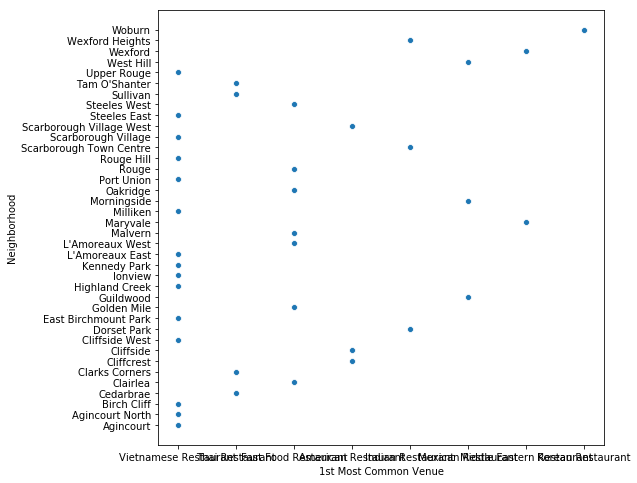

In [149]:
f, ax = plt.subplots(figsize = (8, 8))
sns.scatterplot(y = 'Neighborhood',x = '1st Most Common Venue', 
                data = neighborhoods_venues_sorted_scar)
plt.show()